# Kaggle House Prices

## Initialization & utility functions

In [43]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn import model_selection as ms
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor, IsolationForest
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, RidgeCV, ElasticNetCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor

from pandas.api.types import CategoricalDtype

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [44]:
df_train = pd.read_csv('train.csv', index_col=0)
df_test = pd.read_csv('test.csv', index_col=0)
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [45]:
# create ordinal mappings

qualMapping = {'NA':-1, 'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
expMapping = {'NA':-1, 'No':0, 'Mn':1, 'Av':2, 'Gd':3}
bsmtMapping = {'GLQ':5,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NA':0}
finishMapping = {'NA':-1, 'Unf':0, 'RFn':1, 'Fin':2}
pvmtMapping = {'N':-1, 'P':0, 'Y':2}

mappings = {}
mappings['ExterQual'] = qualMapping
mappings['ExterCond'] = qualMapping
mappings['BsmtExposure'] = expMapping
mappings['BsmtFinType1'] = bsmtMapping
mappings['BsmtFinType2'] = bsmtMapping
mappings['BsmtQual'] = qualMapping
mappings['BsmtCond'] = qualMapping
mappings['HeatingQC'] = qualMapping
mappings['KitchenQual'] = qualMapping

mappings['FireplaceQu'] = qualMapping
mappings['GarageFinish'] = finishMapping
mappings['GarageQual'] = qualMapping
mappings['GarageCond'] = qualMapping
mappings['PavedDrive'] = pvmtMapping
mappings['PoolQC'] = qualMapping

df_neighborhood = df_train[['Neighborhood', 'SalePrice']].groupby('Neighborhood').mean().sort_values('SalePrice')
df_neighborhood['ID'] = list(range(len(df_neighborhood)))
mappings['Neighborhood'] = df_neighborhood.to_dict()['ID']

In [46]:
def generateCategories(df, colName):
    cat = df[[colName, 'SalePrice']].groupby(colName).mean()
    cat = cat.sort_values('SalePrice', ascending=True)
    cat['ID'] = range(len(cat))
    print(cat)
    return cat.to_dict()['ID']
generateCategories(df_train, 'ExterQual')

           SalePrice  ID
ExterQual               
Fa         87985.214   0
TA        144341.313   1
Gd        231633.510   2
Ex        367360.962   3


{'Ex': 3, 'Fa': 0, 'Gd': 2, 'TA': 1}

In [47]:
nanCols = df_train.columns[df_train.isna().any()]
df_train[nanCols].count()

LotFrontage     1201
Alley             91
MasVnrType      1452
MasVnrArea      1452
BsmtQual        1423
BsmtCond        1423
BsmtExposure    1422
BsmtFinType1    1423
BsmtFinType2    1422
Electrical      1459
FireplaceQu      770
GarageType      1379
GarageYrBlt     1379
GarageFinish    1379
GarageQual      1379
GarageCond      1379
PoolQC             7
Fence            281
MiscFeature       54
dtype: int64

In [48]:
oneHotCategoryColumns = set(["MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour",
                            "LotConfig", "LandSlope", "HouseStyle", "RoofStyle",
                            "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation",
                            "Heating", "CentralAir", "Electrical", "GarageType", "PavedDrive",
                            "SaleType", "SaleCondition", "BldgType", "Fence", "Functional"])

ordinalCategoryColumns = set(["ExterQual", "ExterCond", "BsmtQual",
                            "BsmtCond", "BsmtExposure", "BsmtFinType2", "HeatingQC", "KitchenQual",
                            "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "PoolQC",
                            "BsmtFinType1", "Neighborhood"])

numericCategoryColumns = set(["OverallQual", "OverallCond", "GarageCars", "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath"])

specificOneHotColumns = set(["Utilities", "Condition1", "Condition2", "MiscFeature", "PoolArea", "Neighborhood"])

numericColumns = set(["LotFrontage", "LotArea", "MasVnrArea", "TotalBsmtSF", "LowQualFinSF",
                    "GrLivArea", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces",
                    "GarageYrBlt", "WoodDeckSF", "OpenPorchSF",
                    "EnclosedPorch", "3SsnPorch", "ScreenPorch", "MiscVal"])

dateTimeColumns = set(["YearBuilt", "YearRemodAdd", 'DateSold'])

from numbers import Number

def preprocessData(df, verbose=False):
    # modify date column
    df.loc[:, 'DateSold'] = df['YrSold'] + df['MoSold'] / 12.0
    df['YearBuilt'] = df['YearBuilt'].max() - df['YearBuilt']
    df['YearRemodAdd'] = df['YearRemodAdd'].max() - df['YearRemodAdd']
    
    df["PoolArea"].fillna(0.0)
    df["HasPool"] = df["PoolArea"] > 0.0   

    df['GrLivArea'] = df['GrLivArea']**2

    for col in oneHotCategoryColumns:
        df[col].fillna("NA", inplace=True)
        df = pd.concat([df,pd.get_dummies(df[col], prefix=col, prefix_sep="=")],axis=1)

    for col in ordinalCategoryColumns:
        df[col].fillna("NA", inplace=True)
        catList = list(mappings[col].keys())
        catType = CategoricalDtype(categories=catList, ordered=True)
        df.loc[:, col] = df[col].astype(catType)
        df[col + "Code"] = df[col].cat.codes
    
    for col in numericCategoryColumns:
        df[col].fillna(0.0, inplace=True)
    
    for col in numericColumns:
        # fill na values with interpolate
        df.loc[:, col] = df[col].interpolate(method='akima')
        # normalize
        df.loc[:, col] = (df[col] - df[col].mean()) / df[col].std()
       
    df["MiscFeature"].fillna("None", inplace=True)
    df = pd.concat([df,pd.get_dummies(df["MiscFeature"], prefix="MiscFeature", prefix_sep="=")],axis=1)
    
    # add polynomial columns
    df['OverallQual'] = df['OverallQual']**2
    df['ExterQualCode'] = df['ExterQualCode']**2
    df['NeighborhoodCode'] = df['NeighborhoodCode'].astype(float)**2
    df['GarageCars'] = df['GarageCars']**2
    
    df.drop(['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'GarageArea'], axis=1, inplace=True)
    df.drop(oneHotCategoryColumns, axis=1, inplace=True)
    df.drop(ordinalCategoryColumns, axis=1, inplace=True)
    return df

In [49]:
def dropOutliers(df):
    forest = IsolationForest(max_samples=len(df))
    forest.fit(df_train[list(numericColumns)])

    df['Outliers'] = forest.predict(df[list(numericColumns)])
    df['Outliers'] = df['Outliers'].map({1:False, -1:True})
    df_outliers = df[df['Outliers']]
    df = df.drop(df_outliers.index, axis=0)
    return df

In [50]:
def submit(model, df, features, submissionName):
    y_pred = model.predict(df[features])
    df_submission = pd.DataFrame(index=df.index)
    df_submission['SalePrice'] = y_pred
    df_submission.to_csv('submission.csv', header=True)
    df_submission.head()
    return df_submission
    #!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m str(submissionName)

In [63]:
def rmse(y, y_pred):
    return np.square(np.log(y_pred + 1) - np.log(y + 1)).mean() ** 0.5
rmseScorer = make_scorer(rmse)

def testModels(dataframe, features, targetFeature):
    models = [LinearRegression(),
              RidgeCV(alphas=[0.1, 1.0, 10.0]),
              ms.GridSearchCV(Lasso(), param_grid={'alpha':[0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}),
              #ElasticNetCV(cv=5),
              #SGDRegressor(max_iter=5, tol=None),
              #GaussianNB(),
              DecisionTreeRegressor(),
              GradientBoostingRegressor(learning_rate=0.1, n_estimators = 100),
              #ms.GridSearchCV(GradientBoostingRegressor(),
              #                param_grid={'learning_rate':[0.01, 0.05, 0.1, 0.5, 1.0, 5.0],
              #                           'n_estimators':[20,50,100,150,250],
              #                           'max_depth':[2,3,4,5]}),
              RandomForestRegressor()]

    # preparing X and Y before split
    X_all = dataframe[features]
    Y_all = dataframe[targetFeature]
    X_train, X_valid, Y_train, Y_valid = ms.train_test_split(X_all, Y_all, test_size=0.20)

    modelScores = {}
    for i, mod in enumerate(models):
        # cross validation
        scores = ms.cross_val_score(mod, X_all, Y_all, cv=15, scoring=rmseScorer)
        print(mod.__class__.__name__.ljust(30), "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))                                         
        modelScores[mod] = scores.mean()
        
    bestModel = min(modelScores, key=lambda k: modelScores[k])
    bestAccuracy = min(modelScores.values())

    #definitively fit the model on the train data
    bestModel.fit(X_all, Y_all)
    return bestModel, bestAccuracy


## Test Models 1 (3 columns)

AttributeError: Unknown property xlabel

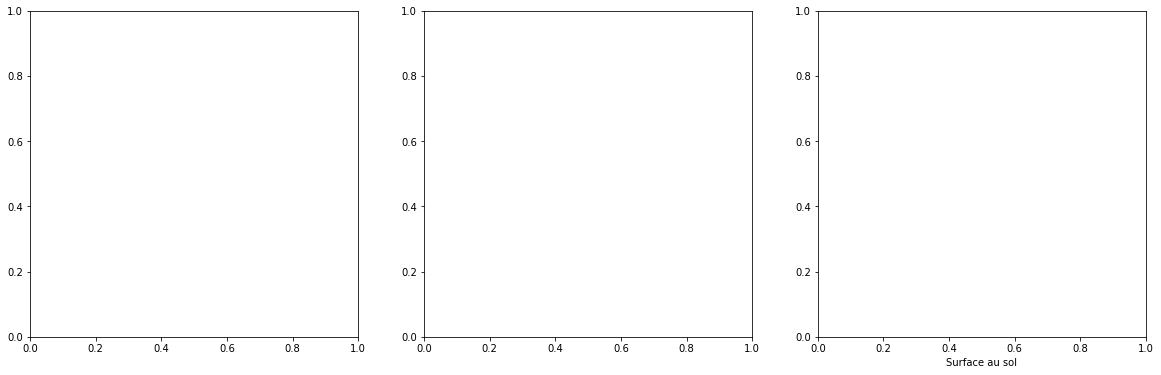

In [80]:
df_train = pd.read_csv('train.csv', index_col=0)
df_train = preprocessData(df_train, verbose = False)
df_train = dropOutliers(df_train)

fig, axes = plt.subplots(figsize=(20, 6), nrows=1, ncols=3)
#scatter plot grlivarea/saleprice
data = pd.concat([df_train['SalePrice'], df_train['GrLivArea']], axis=1)
plt.xlabel("Surface au sol")
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000),ax=axes[0])

#scatter plot totalbsmtsf/saleprice
data = pd.concat([df_train['SalePrice'], df_train['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0,800000),ax=axes[1]);

#box plot overallqual/saleprice
data = pd.concat([df_train['SalePrice'], df_train['OverallQual']], axis=1)
fig = sb.boxplot(x='OverallQual', y="SalePrice", data=data, ax=axes[2])

plt.savefig("3 features.png")
#box plot overallqual/saleprice
#data = pd.concat([df_train['SalePrice'], df_train['YearBuilt']], axis=1)
#fig = sb.boxplot(x='YearBuilt', y="SalePrice", data=data, ax=axes[1,1])

In [109]:
simplestFeatures = ['GrLivArea', 'OverallQual', "TotalBsmtSF"]
className = 'SalePrice'
bestModel, bestAccuracy = testModels(df_train, simplestFeatures, className)

LinearRegression               Accuracy: 0.18 (+/- 0.02)
RidgeCV                        Accuracy: 0.18 (+/- 0.02)
GridSearchCV                   Accuracy: 0.18 (+/- 0.02)
DecisionTreeRegressor          Accuracy: 0.22 (+/- 0.02)
GradientBoostingRegressor      Accuracy: 0.17 (+/- 0.02)


C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow 

C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow 

C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow 

C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:675: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:675: RuntimeWarning: overflow encountered in square
  array_means[:, np.newaxis]) ** 2,
C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce


C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:28

C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:675: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:675: RuntimeWarning: overflow encountered in square
  array_means[:, np.newaxis]) ** 2,
C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.su

C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow 

C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:675: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:675: RuntimeWarning: overflow encountered in square
  array_means[:, np.newaxis]) ** 2,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encoun

C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow 

C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:675: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:675: RuntimeWarning: overflow encountered in square
  array_means[:, np.newaxis]) ** 2,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encoun

GridSearchCV                   Accuracy: 0.17 (+/- 0.02)
RandomForestRegressor          Accuracy: 0.18 (+/- 0.02)


In [110]:
df_test = pd.read_csv('test.csv', index_col=0)
df_test = preprocessData(df_test, verbose = False)
submission = submit(bestModel, df_test, simplestFeatures, className)

In [56]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "3 features"

Successfully submitted to House Prices: Advanced Regression Techniques


## Test Models 2 (6 columns)

In [73]:
df_train = pd.read_csv('train.csv', index_col=0)
df_train = preprocessData(df_train)
df_train = dropOutliers(df_train)

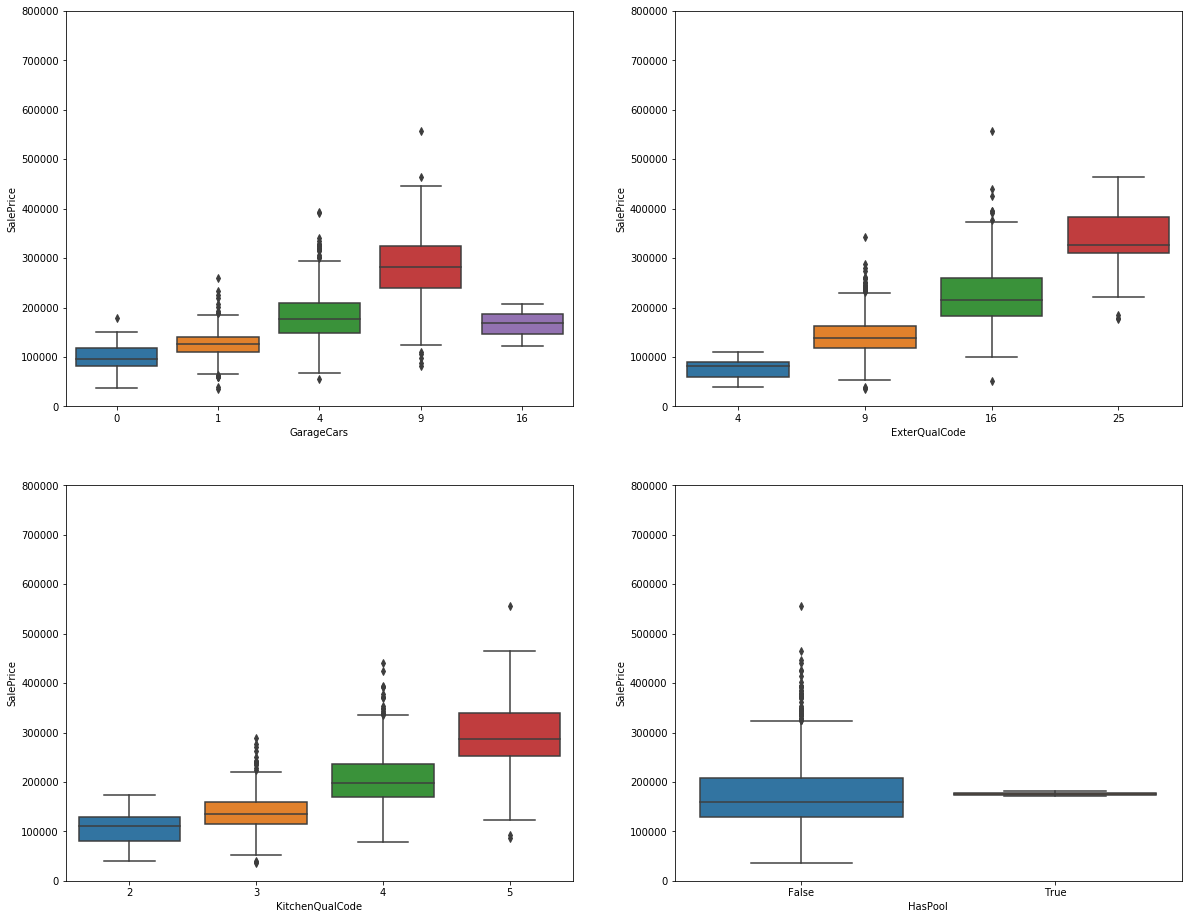

In [74]:
#box plot overallqual/saleprice
featuresToPlot = ['GarageCars', 'ExterQualCode', 'KitchenQualCode', 'HasPool']
fig, axes = plt.subplots(figsize=(20, 16), nrows=int(len(featuresToPlot)/2), ncols=2)
for i, var in enumerate(featuresToPlot):
    data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
    fig = sb.boxplot(x=var, y="SalePrice", data=data, ax=axes[int(i/2), int(i%2)])
    fig.axis(ymin=0, ymax=800000);
plt.savefig('Boxplots.png')

In [28]:
df_train = pd.read_csv('train.csv', index_col=0)
df_train = preprocessData(df_train, verbose = False)
df_train = dropOutliers(df_train)

simplestFeatures = ['GrLivArea', 'OverallQual', "TotalBsmtSF", 'GarageCars', 'ExterQualCode', 'KitchenQualCode', 'NeighborhoodCode']
className = 'SalePrice'
bestModel, bestAccuracy = testModels(df_train, simplestFeatures, className)

LinearRegression               Accuracy: 0.15 (+/- 0.02)
RidgeCV                        Accuracy: 0.15 (+/- 0.02)
GridSearchCV                   Accuracy: 0.15 (+/- 0.02)
DecisionTreeRegressor          Accuracy: 0.19 (+/- 0.02)
GradientBoostingRegressor      Accuracy: 0.14 (+/- 0.02)


C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:28

C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:28

C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow 

C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow 

C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow 

C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:28

C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_metho

C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow 

C:\Users\Amaury\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:28

GridSearchCV                   Accuracy: 0.14 (+/- 0.02)
RandomForestRegressor          Accuracy: 0.16 (+/- 0.02)


In [74]:
df_test = pd.read_csv('test.csv', index_col=0)
df_test = preprocessData(df_test, verbose = False)
submit(bestModel, df_test, simplestFeatures, className)
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "7 features with NeigborhoodCode2"

Successfully submitted to House Prices: Advanced Regression Techniques


## Correlation

In [53]:
df_train_raw = pd.read_csv('train.csv', index_col=0)
df_train = df_train_raw.copy()
df_train = preprocessData(df_train)
corr_matrix = df_train.corr().abs()
#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
os = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
os[:20]

Exterior1st=CBlock     Exterior2nd=CBlock    1.000
BldgType=Duplex        MSSubClass=90         1.000
Street=Grvl            Street=Pave           1.000
CentralAir=N           CentralAir=Y          1.000
PoolArea               HasPool               0.990
SaleCondition=Partial  SaleType=New          0.987
YrSold                 DateSold              0.986
BldgType=2fmCon        MSSubClass=190        0.983
Exterior1st=VinylSd    Exterior2nd=VinylSd   0.978
Exterior1st=CemntBd    Exterior2nd=CmentBd   0.974
Exterior1st=MetalSd    Exterior2nd=MetalSd   0.973
GarageCondCode         GarageQualCode        0.959
HasPool                PoolQCCode            0.954
MiscFeature=None       MiscFeature=Shed      0.951
GarageType=NA          GarageCondCode        0.946
                       GarageQualCode        0.942
MSSubClass=80          HouseStyle=SLvl       0.942
MSSubClass=50          HouseStyle=1.5Fin     0.941
PoolArea               PoolQCCode            0.937
RoofStyle=Gable        RoofStyl

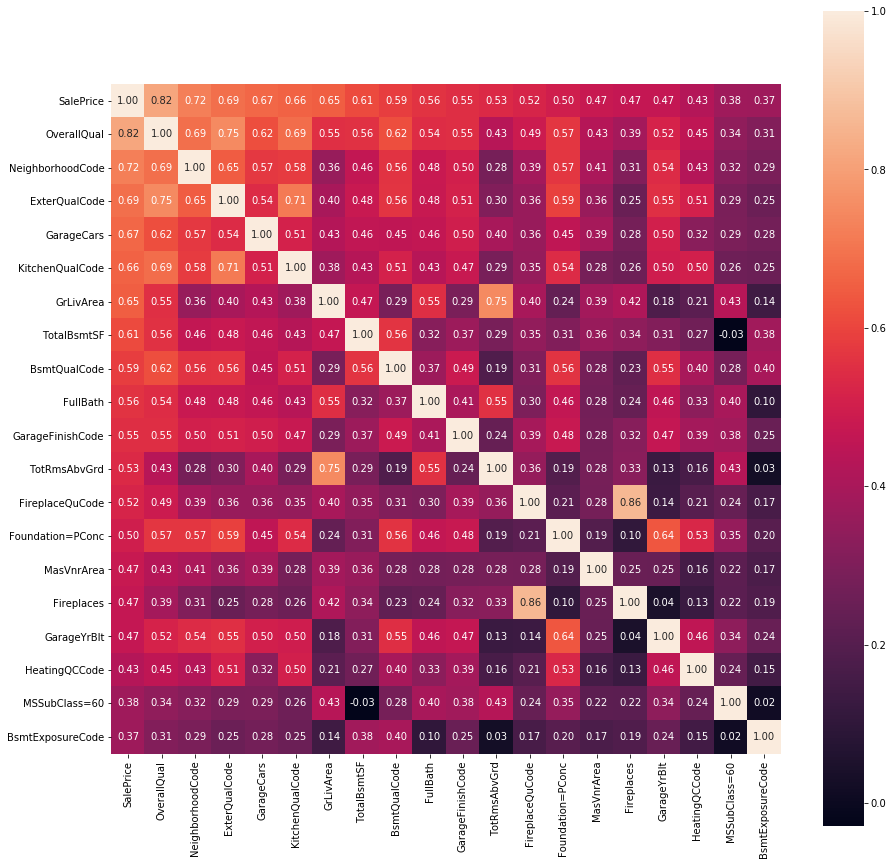

In [54]:
corrmat = df_train.corr()
nbFeatures=20
correlatedColumns = corrmat.nlargest(nbFeatures, 'SalePrice')['SalePrice'].index
corrmat = corrmat.nlargest(nbFeatures, 'SalePrice')[correlatedColumns]
plt.figure(figsize=(15, 15))
sb.heatmap(corrmat,annot=True,square=True,fmt='.2f',yticklabels=correlatedColumns.values,xticklabels=correlatedColumns.values)
plt.savefig("heatmap.png")
plt.show()

In [55]:
corrmat

,SalePrice,OverallQual,NeighborhoodCode,ExterQualCode,GarageCars,KitchenQualCode,GrLivArea,TotalBsmtSF,BsmtQualCode,FullBath,GarageFinishCode,TotRmsAbvGrd,FireplaceQuCode,Foundation=PConc,MasVnrArea,Fireplaces,GarageYrBlt,HeatingQCCode,MSSubClass=60,BsmtExposureCode
SalePrice,1.000,0.817,0.724,0.689,0.671,0.660,0.652,0.614,0.585,0.561,0.549,0.534,0.520,0.498,0.474,0.467,0.465,0.428,0.377,0.375
OverallQual,0.817,1.000,0.690,0.749,0.618,0.685,0.550,0.555,0.622,0.544,0.547,0.433,0.489,0.568,0.429,0.392,0.516,0.454,0.342,0.309
NeighborhoodCode,0.724,0.690,1.000,0.649,0.572,0.582,0.358,0.461,0.562,0.481,0.503,0.284,0.390,0.568,0.405,0.305,0.541,0.425,0.317,0.292
ExterQualCode,0.689,0.749,0.649,1.000,0.538,0.712,0.398,0.478,0.562,0.477,0.511,0.304,0.363,0.592,0.362,0.251,0.550,0.509,0.289,0.252
GarageCars,0.671,0.618,0.572,0.538,1.000,0.512,0.429,0.459,0.455,0.464,0.498,0.399,0.362,0.454,0.393,0.280,0.503,0.325,0.293,0.275
KitchenQualCode,0.660,0.685,0.582,0.712,0.512,1.000,0.378,0.433,0.511,0.435,0.475,0.287,0.354,0.538,0.284,0.256,0.495,0.504,0.264,0.255
GrLivArea,0.652,0.550,0.358,0.398,0.429,0.378,1.000,0.467,0.287,0.548,0.291,0.748,0.401,0.237,0.388,0.416,0.180,0.214,0.433,0.141
TotalBsmtSF,0.614,0.555,0.461,0.478,0.459,0.433,0.467,1.000,0.564,0.324,0.372,0.286,0.348,0.308,0.361,0.340,0.312,0.266,-0.029,0.383
BsmtQualCode,0.585,0.622,0.562,0.562,0.455,0.511,0.287,0.564,1.000,0.371,0.485,0.186,0.307,0.561,0.279,0.230,0.546,0.397,0.280,0.399
FullBath,0.561,0.544,0.481,0.477,0.464,0.435,0.548,0.324,0.371,1.000,0.408,0.555,0.297,0.462,0.276,0.244,0.456,0.333,0.398,0.099


In [56]:
df_train.tail()

,LotFrontage,LotArea,Utilities,Condition1,Condition2,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,GarageFinishCode,BsmtExposureCode,BsmtFinType2Code,KitchenQualCode,HeatingQCCode,MiscFeature=Gar2,MiscFeature=None,MiscFeature=Othr,MiscFeature=Shed,MiscFeature=TenC
Id,,,,,,,,,,,,,,,,,,,,,
1456,-0.354,-0.260,AllPub,Norm,Norm,36,5,11,10,-0.573,...,2,1,5,3,5,0,1,0,0,0
1457,0.633,0.266,AllPub,Norm,Norm,36,6,32,22,0.085,...,1,1,3,3,3,0,1,0,0,0
1458,-0.182,-0.148,AllPub,Norm,Norm,49,9,69,4,-0.573,...,2,1,5,4,5,0,0,0,1,0
1459,-0.096,-0.080,AllPub,Norm,Norm,25,6,60,14,-0.573,...,1,2,3,4,4,0,1,0,0,0
1460,0.204,-0.058,AllPub,Norm,Norm,25,6,45,45,-0.573,...,3,1,4,3,4,0,1,0,0,0


In [57]:
correlatedColumnsList = list(correlatedColumns)
correlatedColumnsList.remove('SalePrice')
print(correlatedColumnsList)
bestModel, bestAccuracy = testModels(df_train, correlatedColumnsList, 'SalePrice')

['OverallQual', 'NeighborhoodCode', 'ExterQualCode', 'GarageCars', 'KitchenQualCode', 'GrLivArea', 'TotalBsmtSF', 'BsmtQualCode', 'FullBath', 'GarageFinishCode', 'TotRmsAbvGrd', 'FireplaceQuCode', 'Foundation=PConc', 'MasVnrArea', 'Fireplaces', 'GarageYrBlt', 'HeatingQCCode', 'MSSubClass=60', 'BsmtExposureCode']
LinearRegression               Accuracy: 0.18 (+/- 0.07)
RidgeCV                        Accuracy: 0.18 (+/- 0.06)
GridSearchCV                   Accuracy: 0.18 (+/- 0.06)
DecisionTreeRegressor          Accuracy: 0.22 (+/- 0.04)
GradientBoostingRegressor      Accuracy: 0.14 (+/- 0.02)
RandomForestRegressor          Accuracy: 0.16 (+/- 0.03)


In [58]:
nbFeatures = 20
className = 'SalePrice'

In [70]:
df_train_raw = pd.read_csv('train.csv', index_col=0)
df_train = df_train_raw.copy()
df_train = preprocessData(df_train)

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_train = df_train.select_dtypes(include=numerics)

Y = df_train[className]
X = df_train.drop(className, axis=1)

# Build a forest and compute the feature importances
forest = ExtraTreesRegressor(n_estimators=250, random_state=0)
forest.fit(X, Y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking ("+str(nbFeatures)+" most important):")

for f in range(nbFeatures):
    print("%d. feature %d (%s) (%f)" %
          (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))
importantFeatures = X.columns[indices[:nbFeatures]]

Feature ranking (20 most important):
1. feature 2 (OverallQual) (0.306132)
2. feature 30 (NeighborhoodCode) (0.183490)
3. feature 19 (GarageCars) (0.154740)
4. feature 9 (GrLivArea) (0.087596)
5. feature 7 (TotalBsmtSF) (0.040010)
6. feature 12 (FullBath) (0.036473)
7. feature 17 (Fireplaces) (0.021183)
8. feature 4 (YearBuilt) (0.018861)
9. feature 5 (YearRemodAdd) (0.016971)
10. feature 16 (TotRmsAbvGrd) (0.016259)
11. feature 10 (BsmtFullBath) (0.014778)
12. feature 1 (LotArea) (0.012943)
13. feature 14 (BedroomAbvGr) (0.010307)
14. feature 3 (OverallCond) (0.007955)
15. feature 20 (WoodDeckSF) (0.007522)
16. feature 18 (GarageYrBlt) (0.007257)
17. feature 6 (MasVnrArea) (0.007107)
18. feature 0 (LotFrontage) (0.006746)
19. feature 21 (OpenPorchSF) (0.006644)
20. feature 13 (HalfBath) (0.006014)


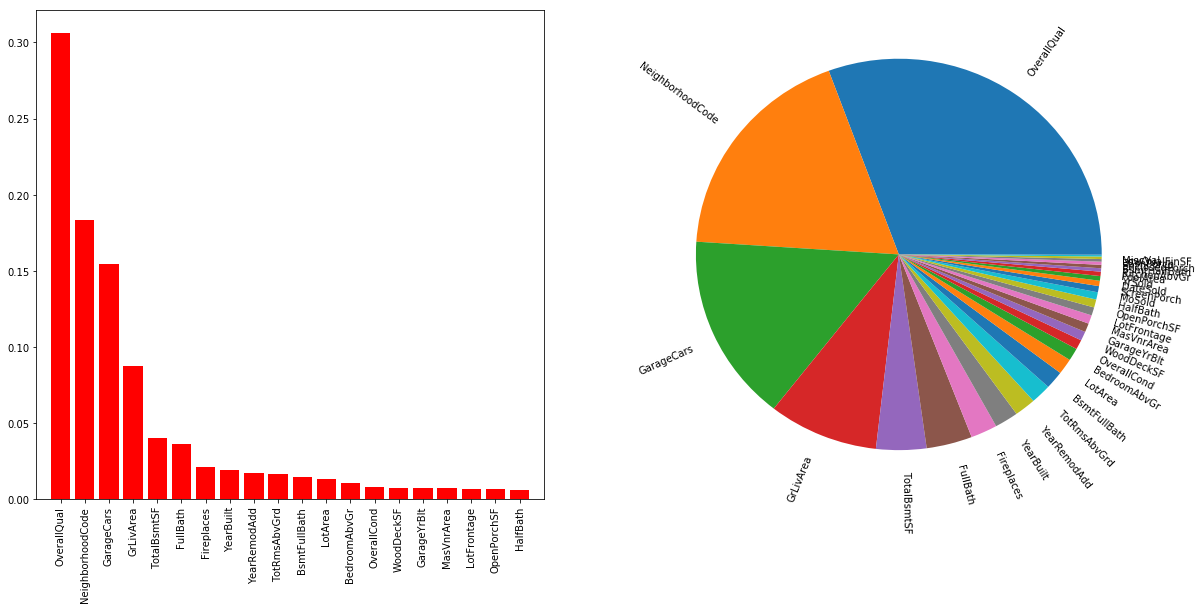

In [71]:
# Plot the feature importances of the forest
plt.figure(figsize=(20, 9))
plt.title("Feature importances")

plt.subplot(1, 2, 1)
plt.bar(range(nbFeatures),importances[indices[:nbFeatures]],color="r",align="center")
plt.xticks(range(nbFeatures), X.columns[indices[:nbFeatures]], rotation=90)
plt.xlim([-1, nbFeatures])
plt.savefig("FeatureImportance.png")

plt.subplot(1, 2, 2)
plt.pie(importances[indices], labels=X.columns[indices], rotatelabels=True)
plt.show()

## Test Model 3 (20 most important features)

In [77]:
bestModel, bestAccuracy = testModels(df_train, importantFeatures, 'SalePrice')
print(bestModel)

LinearRegression               Accuracy: 0.13 (+/- 0.01)
RidgeCV                        Accuracy: 0.13 (+/- 0.01)
GridSearchCV                   Accuracy: 0.13 (+/- 0.01)
DecisionTreeRegressor          Accuracy: 0.19 (+/- 0.03)
GradientBoostingRegressor      Accuracy: 0.12 (+/- 0.02)
RandomForestRegressor          Accuracy: 0.14 (+/- 0.02)
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


In [65]:
print(bestModel)
df_test = pd.read_csv('test.csv', index_col=0)
df_test = preprocessData(df_test)
submission = submit(bestModel, df_test, importantFeatures, "Best 20")

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


In [66]:
gsCVModel = ms.GridSearchCV(GradientBoostingRegressor(),
                              param_grid={'learning_rate':[0.05, 0.1, 0.5, 1.0],
                                         'n_estimators':[50,100,150]})
X_all = df_train[importantFeatures]
Y_all = df_train['SalePrice']
#scores = ms.cross_val_score(gsCVModel, X_all, Y_all, cv=15, scoring=rmseScorer)
#print(scores)
gsCVModel.fit(X_all, Y_all)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.05, 0.1, 0.5, 1.0], 'n_estimators': [50, 100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [67]:
print(gsCVModel)
df_test = pd.read_csv('test.csv', index_col=0)
df_test = preprocessData(df_test)
submission = submit(gsCVModel, df_test, importantFeatures, "Grid search on GradientBoostRegressor")

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.05, 0.1, 0.5, 1.0], 'n_estimators': [50, 100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


In [68]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "Grid search on GradientBoostRegressor"

Successfully submitted to House Prices: Advanced Regression Techniques
